In [1]:
import warnings
from io import BytesIO
from pathlib import Path
from urllib.parse import urlparse
from urllib.request import urlopen, urlretrieve
from zipfile import ZipFile, is_zipfile
import os

import pandas as pd
import socceraction.vaep.features as features
import socceraction.vaep.labels as labels

from sklearn.metrics import brier_score_loss, roc_auc_score, log_loss
from socceraction.spadl.wyscout import convert_to_actions
from socceraction.vaep.formula import value
import socceraction.vaep.formula as vaepformula
from tqdm.notebook import tqdm
from xgboost import XGBClassifier
import tqdm
import random

import socceraction.atomic.spadl as atomicspadl
import socceraction.atomic.vaep.features as fs
import socceraction.atomic.vaep.labels as lab

import socceraction.atomic.spadl as atomicspadl
import socceraction.atomic.vaep.formula as vaepformula

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier



warnings.filterwarnings('ignore', category=pd.io.pytables.PerformanceWarning)


In [2]:
%load_ext autoreload
%autoreload 2
from socceraction.data.statsbomb import StatsBombLoader
import socceraction.spadl as spadl
import socceraction.atomic.spadl as atomicspadl
from socceraction.data.wyscout import PublicWyscoutLoader



In [3]:

wyscout = PublicWyscoutLoader(root = '/Users/leonardoyang/Desktop/Tesi/Wyscout/raw/data', download=False)

In [4]:
comp = [
     #'England'
     #'France',
     #'Germany',
     'Italy',
     #'Spain'
]

In [5]:
##DA qui

In [6]:
competitions = wyscout.competitions()
competitions.info()

<class 'pandera.typing.pandas.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   competition_id      7 non-null      int64 
 1   season_id           7 non-null      int64 
 2   country_name        7 non-null      object
 3   competition_name    7 non-null      object
 4   competition_gender  7 non-null      object
 5   season_name         7 non-null      object
dtypes: int64(2), object(4)
memory usage: 464.0+ bytes


In [7]:
selected_competitions = competitions[(competitions['country_name'] =='Italy')]
selected_competitions

,competition_id,season_id,country_name,competition_name,competition_gender,season_name
0,524,181248,Italy,Italian first division,male,2017/2018


### Append home and away goals to the game dataset

In [8]:
## Create empty list for DataFrames
dfs_matches = []

## Loop through the competition files for the selected competition(s) and append DataFrame to dfs_matches list
for competition in selected_competitions['country_name']:
    competition_name = competition.replace(' ', '_')
    file_matches = f'matches_{competition_name}.json'
    df_matches = pd.read_json('/Users/leonardoyang/Desktop/Tesi/Wyscout/raw/Data/' + file_matches)
    dfs_matches.append(df_matches)

## Concatenate DataFrames to one DataFrame
df_matches = pd.concat(dfs_matches)
df_matches= df_matches.reset_index()

In [9]:
home_score, away_score = [],[]
for i in range(len(df_matches)) : 
    home_id, away_id = df_matches['teamsData'][i].keys()
    if df_matches['teamsData'][i][home_id]['side'] == 'away':
        home_id, away_id = away_id, home_id
    home_score.append(df_matches['teamsData'][i][home_id]['score'])
    away_score.append(df_matches['teamsData'][i][away_id]['score'])


In [10]:
df_matches['home_score'] = home_score
df_matches['away_score'] = away_score
df_matches = df_matches[['seasonId','wyId','label','competitionId', 'home_score','away_score']]
df_matches.rename(columns={'seasonId':'season_id', 'wyId':'game_id','competitionId':'competition_id'}, inplace = True)

In [11]:
df_matches.head()

,season_id,game_id,label,competition_id,home_score,away_score
0,181248,2576335,"Lazio - Internazionale, 2 - 3",524,2,3
1,181248,2576336,"Sassuolo - Roma, 0 - 1",524,0,1
2,181248,2576329,"Cagliari - Atalanta, 1 - 0",524,1,0
3,181248,2576330,"Chievo - Benevento, 1 - 0",524,1,0
4,181248,2576331,"Udinese - Bologna, 1 - 0",524,1,0


In [12]:
# Get games from all selected competitions
games = pd.concat([
    wyscout.games(row.competition_id, row.season_id)
    for row in selected_competitions.itertuples()
])

In [13]:
games.head()

,game_id,competition_id,season_id,game_date,game_day,home_team_id,away_team_id
0,2576335,524,181248,2018-05-20 18:45:00,38,3162,3161
1,2576336,524,181248,2018-05-20 18:45:00,38,3315,3158
2,2576329,524,181248,2018-05-20 16:00:00,38,3173,3172
3,2576330,524,181248,2018-05-20 16:00:00,38,3165,3219
4,2576331,524,181248,2018-05-20 16:00:00,38,3163,3166


In [14]:
match_goals = pd.merge(games, df_matches, on =['game_id','competition_id','season_id'])
match_goals.drop(['label'],axis = 1, inplace = True)
games = match_goals

In [15]:
games[["home_team_id", "away_team_id", "game_date","home_score", "away_score"]]

,home_team_id,away_team_id,game_date,home_score,away_score
0,3162,3161,2018-05-20 18:45:00,2,3
1,3315,3158,2018-05-20 18:45:00,0,1
2,3173,3172,2018-05-20 16:00:00,1,0
3,3165,3219,2018-05-20 16:00:00,1,0
4,3163,3166,2018-05-20 16:00:00,1,0
...,...,...,...,...,...
375,3315,3193,2017-08-20 18:45:00,0,0
376,3163,3165,2017-08-20 18:45:00,1,2
377,3172,3158,2017-08-20 16:00:00,0,1
378,3194,3187,2017-08-19 18:45:00,1,3


In [16]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380 entries, 0 to 379
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   game_id         380 non-null    int64         
 1   competition_id  380 non-null    int64         
 2   season_id       380 non-null    int64         
 3   game_date       380 non-null    datetime64[ns]
 4   game_day        380 non-null    int64         
 5   home_team_id    380 non-null    int64         
 6   away_team_id    380 non-null    int64         
 7   home_score      380 non-null    int64         
 8   away_score      380 non-null    int64         
dtypes: datetime64[ns](1), int64(8)
memory usage: 29.7 KB


### Convert event to actions

In [17]:
#Store everything in the HDF
datafolder = "/Users/leonardoyang/Desktop/data-fifa/Ita"

In [18]:
#To upload the DF
spadl_h5 = os.path.join(datafolder, "atomic_spadl-wyscout.h5")

In [19]:
pd.HDFStore(spadl_h5)['teams'].reset_index().drop('index', axis =1)

,team_id,team_name_short,team_name
0,3162,Lazio,SS Lazio
1,3161,Internazionale,FC Internazionale Milano
2,3158,Roma,AS Roma
3,3315,Sassuolo,US Sassuolo Calcio
4,3173,Cagliari,Cagliari Calcio
5,3172,Atalanta,Atalanta Bergamasca Calcio
6,3165,Chievo,AC Chievo Verona
7,3219,Benevento,Benevento Calcio
8,3166,Bologna,Bologna FC 1909
9,3163,Udinese,Udinese Calcio


In [20]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    # Select England vs Belgium game at World Cup
    game = games[(games.country_name == "Italy") 
                  & (games.home_team_name_short == "Internazionale")
                  & (games.away_team_name_short== "Milan")]
    game_id = game.game_id.values[0]
    atomic_actions = spadlstore[f"actions/game_{game_id}"]
    atomic_actions = (
        atomic_actions
        .merge(atomicspadl.actiontypes_df(), how="left")
        .merge(spadl.bodyparts_df(), how="left")
        .merge(spadlstore["players"], how="left")
        .merge(spadlstore["teams"], how="left")
    )

# use nickname if available else use full name
atomic_actions["player_name"] = atomic_actions[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
del atomic_actions['nickname']
atomic_actions[:5]

,game_id,original_event_id,action_id,period_id,time_seconds,team_id,player_id,x,y,dx,dy,type_id,bodypart_id,type_name,bodypart_name,player_name,team_name_short,team_name
0,2576034,196692208,0,1,2.532778,3157,135927,51.45,32.64,16.8,7.48,0,0,pass,foot,André Silva,Milan,AC Milan
1,2576034,196692208,1,1,3.325886,3157,37732,68.25,40.12,0.0,0.00,23,0,receival,foot,L. Biglia,Milan,AC Milan
2,2576034,196692209,2,1,4.118994,3157,37732,68.25,40.12,-10.5,15.64,0,0,pass,foot,L. Biglia,Milan,AC Milan
3,2576034,196692209,3,1,5.348591,3157,285109,57.75,55.76,0.0,0.00,23,0,receival,foot,F. Kessié,Milan,AC Milan
4,2576034,196692210,4,1,6.578187,3157,285109,57.75,55.76,-12.6,10.88,0,0,pass,foot,F. Kessié,Milan,AC Milan


2017-10-15 18:45:00, FC Internazionale Milano - AC Milan : 3-2 , M. Icardi 62'


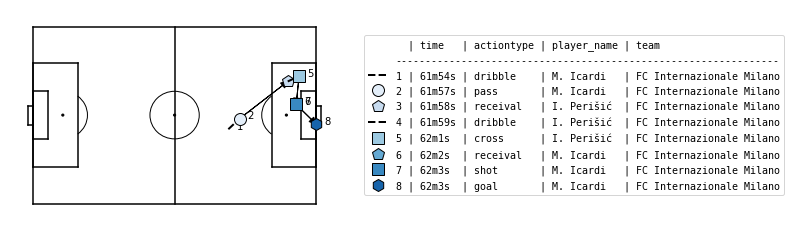

In [21]:
#select a goal to plot
import matplotsoccer

for shot in list(atomic_actions[(atomic_actions.type_name == "goal")][2:3].index):
    a = atomic_actions[shot-7:shot+1].copy()

    a["start_x"] = a.x
    a["start_y"] = a.y
    a["end_x"] = a.x + a.dx
    a["end_y"] = a.y + a.dy

    g = game.iloc[0]
    minute = int((a.period_id.values[0] - 1) * 45 + a.time_seconds.values[0] // 60)
    game_info = f"{g.game_date}, {g.home_team_name} - {g.away_team_name} : {g.home_score}-{g.away_score} , {a[-1:].player_name.values[0]} {minute + 1}'"
    print(game_info)

    def nice_time(row):
        minute = int((row.period_id-1) * 45 + row.time_seconds // 60)
        second = int(row.time_seconds % 60)
        return f"{minute}m{second}s"

    a["nice_time"] = a.apply(nice_time,axis=1)
    labels = a[["nice_time", "type_name", "player_name", "team_name"]]

    matplotsoccer.actions(
        location=a[["start_x", "start_y", "end_x", "end_y"]],
        action_type=a.type_name,
        team= a.team_name,
        label=labels,
        labeltitle=["time", "actiontype", "player_name", "team"],
        zoom=False,
        figsize=6
    )

In [22]:
df_players = pd.read_json('/Users/leonardoyang/Desktop/Tesi/Wyscout/raw/players.json')
df_players = df_players[['wyId','shortName','role']]

Role = []
for i in range(len(df_players)):
    Role.append(df_players['role'][i]['name'])

df_players['Role'] = Role
df_players.drop('role', axis = 1,inplace = True)

## Compute features and labels

In [23]:
features_h5 = os.path.join(datafolder, "atomic_features.h5")
labels_h5 = os.path.join(datafolder, "atomic_labels.h5")

In [24]:
games = pd.HDFStore(spadl_h5)['games']
print("nb of games:", len(games))

nb of games: 380


In [25]:
#Labels
#goal = True if goal from a shot
#Score = True if within next 10 actions goal
#concedes = True if within next 10 actions goal
#Chi ha palla è score, se durante azione c'è qualche intervento avversario c'è concedes = true.
#Goal è true solo se shot, score e concedes ci sono comunque.

### Compute Probabilities

In [26]:
predictions_h5 = os.path.join(datafolder, "atomic-predictions-one-action.h5")

In [27]:
# 1. Select feature set X
xfns = [
    #fs.actiontype,
    fs.actiontype_onehot,
    #fs.bodypart,
    fs.bodypart_onehot,
    fs.goalscore,
    fs.location,
    fs.polar,
    fs.direction,
    fs.team,
    fs.time,
    fs.time_delta
]
nb_prev_actions = 3

Xcols = fs.feature_column_names(xfns, nb_prev_actions)

def getXY(games, Xcols):
    # generate the columns of the selected feature
    X = []
    for game_id in tqdm.tqdm(games.game_id, desc="Selecting features"): #aggiungi azioni di ogni partita
        Xi = pd.HDFStore(features_h5) [f"game_{game_id}"]
        X.append(Xi[Xcols])
    X = pd.concat(X).reset_index(drop=True)

    # 2. Select label Y
    Ycols = ["scores", "concedes"]
    Y = []
    for game_id in tqdm.tqdm(games.game_id, desc="Selecting label"):
        Yi = pd.HDFStore(labels_h5)[f"game_{game_id}"]
        Y.append(Yi[Ycols])
    Y = pd.concat(Y).reset_index(drop=True)
    return X, Y

#print("X:", list(X.columns))
#print("Y:", list(Y.columns))

In [28]:
#'goalscore_team','goalscore_opponent' = goal segnati fin'ora dalla squadra che fa l'ultima azione.

## Model 

In [29]:
### load model 
import pickle
model = pickle.load(open('trained_model.sav', 'rb'))

In [30]:
#Prediction per tutte le partite
gamesX, gamesY = getXY(games,Xcols)
Y_hat = pd.DataFrame()
for col in gamesY.columns:
    Y_hat[col] = [p[1] for p in model[col].predict_proba(gamesX)]

Selecting label: 100%|██████████| 380/380 [00:05<00:00, 68.04it/s]


In [31]:
# get rows with game id per action
A = []
for game_id in tqdm.tqdm(games.game_id, "Loading actions of each game"):    #azioni per ogni partita del test
    Ai = pd.HDFStore(spadl_h5) [f"actions/game_{game_id}"]
    A.append(Ai[["game_id"]])
A = pd.concat(A)
A = A.reset_index(drop=True)

# concatenate action game id rows with predictions and save per game
grouped_predictions = pd.concat([A, Y_hat], axis=1).groupby("game_id")
for k,df in tqdm.tqdm(grouped_predictions, desc="Saving predictions per game"):
    df = df.reset_index(drop=True)
    df[Y_hat.columns].to_hdf(predictions_h5, f"game_{int(k)}")

Saving predictions per game: 100%|██████████| 380/380 [00:15<00:00, 24.31it/s]


## VAEP

In [32]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    players = spadlstore["players"]
    teams = spadlstore["teams"]
print("nb of games:", len(games))

nb of games: 380


In [33]:
#For each game in the test set, append the predictions and compute vaep
A = []
for game in tqdm.tqdm(list(games.itertuples()), desc="Loading actions"):
    actions = pd.HDFStore(spadl_h5) [f"actions/game_{game.game_id}"]
    actions = (
        atomicspadl.add_names(actions)
        .merge(players, how="left")
        .merge(teams, how="left",)
        .sort_values(["game_id", "period_id", "action_id"])
        .reset_index(drop=True)
    )
    preds = pd.HDFStore(predictions_h5) [f"game_{game.game_id}"]
    values = vaepformula.value(actions, preds.scores, preds.concedes)
    A.append(pd.concat([actions, preds, values], axis=1))
A = pd.concat(A).sort_values(["game_id", "period_id", "time_seconds"]).reset_index(drop=True)
A.columns

Loading actions: 100%|██████████| 380/380 [00:44<00:00,  8.54it/s]


Index(['game_id', 'original_event_id', 'action_id', 'period_id',
       'time_seconds', 'team_id', 'player_id', 'x', 'y', 'dx', 'dy', 'type_id',
       'bodypart_id', 'type_name', 'bodypart_name', 'player_name', 'nickname',
       'team_name_short', 'team_name', 'scores', 'concedes', 'offensive_value',
       'defensive_value', 'vaep_value'],
      dtype='object')

In [34]:
#Df with players and roles
df_players = pd.read_json('/Users/leonardoyang/Desktop/Tesi/Wyscout/raw/players.json')
df_players = df_players[['wyId','shortName','role','currentTeamId']]
Role = []
for i in range(len(df_players)):
    Role.append(df_players['role'][i]['name'])

df_players['Role'] = Role
df_players.drop('role', axis = 1,inplace = True)

df_players = pd.merge(df_players, teams, left_on = 'currentTeamId', right_on = 'team_id').drop(['currentTeamId','team_id','team_name'], axis = 1).rename(columns={'team_name_short':'Team'})

In [35]:
A["count"] = 1

# Compute each player's number of actions and total VAEP values
playersR = (
    A[["player_id", "vaep_value", "offensive_value", "defensive_value", "count"]]
    .groupby(["player_id"])
    .sum()
    .reset_index()
)
# Add player names
playersR = playersR.merge(players[["player_id", "nickname", "player_name"]], how="left")
playersR = pd.merge(playersR, df_players, left_on ='player_id', right_on = 'wyId', how = 'left').drop(['wyId','shortName'], axis = 1)
playersR["player_name"] = playersR[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
# Show results
playersR = playersR[["player_id", "player_name","Role", "Team","vaep_value", "offensive_value", "defensive_value", "count"]]
playersR.sort_values("vaep_value", ascending=False)[:20]

,player_id,player_name,Role,Team,vaep_value,offensive_value,defensive_value,count
182,21298,Nicolas,Goalkeeper,Hellas Verona,33.191405,2.102410,31.088995,2536
374,206314,M. Icardi,Forward,Internazionale,29.894157,28.994733,0.899425,1310
192,21384,C. Immobile,Forward,Lazio,29.745438,29.699320,0.046119,2161
3,122,D. Mertens,Forward,Napoli,27.143875,26.673017,0.470858,2668
104,20633,S. Sorrentino,Goalkeeper,Chievo,25.157254,1.600248,23.557006,1990
37,8327,E. Džeko,Forward,Roma,25.058717,23.495770,1.562946,2198
13,3323,G. Higuaín,Forward,Milan,24.947571,23.778553,1.169018,2047
197,21494,A. Cordaz,Goalkeeper,Crotone,24.447464,2.236261,22.211202,1994
319,89186,P. Dybala,Forward,Juventus,22.217792,21.677373,0.540418,3250
43,14812,I. Perišić,Midfielder,Internazionale,21.836799,19.833861,2.002938,4074


In [36]:
# Normalize for minutes played
pg = pd.HDFStore(spadl_h5) ["player_games"]
pg = pg[pg.game_id.isin(games.game_id)]
mp = pg[["player_id", "minutes_played"]].groupby("player_id").sum().reset_index()

stats = playersR.merge(mp)
stats = stats[stats.minutes_played > 1200] # at least 19 full games played
stats["vaep_rating"] = stats.vaep_value * 90 / stats.minutes_played
stats["offensive_rating"] = stats.offensive_value * 90 / stats.minutes_played
stats["defensive_rating"] = stats.defensive_value * 90 / stats.minutes_played
stats.sort_values("vaep_rating",ascending=False)[:10]

,player_id,player_name,Role,Team,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
191,21384,C. Immobile,Forward,Lazio,29.745438,29.699320,0.046119,2161,2816,0.950671,0.949197,0.001474
181,21298,Nicolas,Goalkeeper,Hellas Verona,33.191405,2.102410,31.088995,2536,3429,0.871165,0.055181,0.815984
373,206314,M. Icardi,Forward,Internazionale,29.894157,28.994733,0.899425,1310,3103,0.867056,0.840969,0.026087
318,89186,P. Dybala,Forward,Juventus,22.217792,21.677373,0.540418,3250,2491,0.802730,0.783205,0.019525
2,122,D. Mertens,Forward,Napoli,27.143875,26.673017,0.470858,2668,3142,0.777514,0.764027,0.013487
12,3323,G. Higuaín,Forward,Milan,24.947571,23.778553,1.169018,2047,2977,0.754209,0.718868,0.035341
475,350032,C. Ünder,Forward,Roma,10.648802,10.261397,0.387405,1204,1318,0.727156,0.700702,0.026454
36,8327,E. Džeko,Forward,Roma,25.058717,23.495770,1.562946,2198,3177,0.709879,0.665603,0.044276
458,333913,K. Lasagna,Forward,Udinese,17.465562,17.256119,0.209442,1273,2253,0.697692,0.689326,0.008367
17,3484,Luis Alberto,Midfielder,Lazio,21.669055,20.203749,1.465306,4107,2805,0.695264,0.648249,0.047015


In [37]:
# Normalize for minutes played
pg = pd.HDFStore(spadl_h5) ["player_games"]
pg = pg[pg.game_id.isin(games.game_id)]
mp = pg[["player_id", "minutes_played"]].groupby("player_id").sum().reset_index()

stats = playersR.merge(mp)
stats = stats[stats.minutes_played > 1200] # at least 19 full games played
stats["vaep_rating"] = stats.vaep_value * 90 / stats.minutes_played
stats["offensive_rating"] = stats.offensive_value * 90 / stats.minutes_played
stats["defensive_rating"] = stats.defensive_value * 90 / stats.minutes_played
stats.sort_values("vaep_rating",ascending=False)[:10]

,player_id,player_name,Role,Team,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
191,21384,C. Immobile,Forward,Lazio,29.745438,29.699320,0.046119,2161,2816,0.950671,0.949197,0.001474
181,21298,Nicolas,Goalkeeper,Hellas Verona,33.191405,2.102410,31.088995,2536,3429,0.871165,0.055181,0.815984
373,206314,M. Icardi,Forward,Internazionale,29.894157,28.994733,0.899425,1310,3103,0.867056,0.840969,0.026087
318,89186,P. Dybala,Forward,Juventus,22.217792,21.677373,0.540418,3250,2491,0.802730,0.783205,0.019525
2,122,D. Mertens,Forward,Napoli,27.143875,26.673017,0.470858,2668,3142,0.777514,0.764027,0.013487
12,3323,G. Higuaín,Forward,Milan,24.947571,23.778553,1.169018,2047,2977,0.754209,0.718868,0.035341
475,350032,C. Ünder,Forward,Roma,10.648802,10.261397,0.387405,1204,1318,0.727156,0.700702,0.026454
36,8327,E. Džeko,Forward,Roma,25.058717,23.495770,1.562946,2198,3177,0.709879,0.665603,0.044276
458,333913,K. Lasagna,Forward,Udinese,17.465562,17.256119,0.209442,1273,2253,0.697692,0.689326,0.008367
17,3484,Luis Alberto,Midfielder,Lazio,21.669055,20.203749,1.465306,4107,2805,0.695264,0.648249,0.047015


In [38]:
copy = stats.sort_values("vaep_rating",ascending=False)[:10].copy()
copy[['player_name','Role','Team','vaep_rating']]

,player_name,Role,Team,vaep_rating
191,C. Immobile,Forward,Lazio,0.950671
181,Nicolas,Goalkeeper,Hellas Verona,0.871165
373,M. Icardi,Forward,Internazionale,0.867056
318,P. Dybala,Forward,Juventus,0.802730
2,D. Mertens,Forward,Napoli,0.777514
12,G. Higuaín,Forward,Milan,0.754209
475,C. Ünder,Forward,Roma,0.727156
36,E. Džeko,Forward,Roma,0.709879
458,K. Lasagna,Forward,Udinese,0.697692
17,Luis Alberto,Midfielder,Lazio,0.695264


In [39]:
stats[stats.Role == "Forward"].sort_values('vaep_rating', ascending = False)[:10]

,player_id,player_name,Role,Team,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
191,21384,C. Immobile,Forward,Lazio,29.745438,29.699320,0.046119,2161,2816,0.950671,0.949197,0.001474
373,206314,M. Icardi,Forward,Internazionale,29.894157,28.994733,0.899425,1310,3103,0.867056,0.840969,0.026087
318,89186,P. Dybala,Forward,Juventus,22.217792,21.677373,0.540418,3250,2491,0.802730,0.783205,0.019525
2,122,D. Mertens,Forward,Napoli,27.143875,26.673017,0.470858,2668,3142,0.777514,0.764027,0.013487
12,3323,G. Higuaín,Forward,Milan,24.947571,23.778553,1.169018,2047,2977,0.754209,0.718868,0.035341
475,350032,C. Ünder,Forward,Roma,10.648802,10.261397,0.387405,1204,1318,0.727156,0.700702,0.026454
36,8327,E. Džeko,Forward,Roma,25.058717,23.495770,1.562946,2198,3177,0.709879,0.665603,0.044276
458,333913,K. Lasagna,Forward,Udinese,17.465562,17.256119,0.209442,1273,2253,0.697692,0.689326,0.008367
312,86243,D. Zapata,Forward,Sampdoria,16.953640,15.684469,1.269171,1562,2227,0.685149,0.633858,0.051291
129,20820,J. Iličić,Forward,Atalanta,15.922427,14.865211,1.057216,3023,2112,0.678513,0.633461,0.045052


In [40]:
stats[stats.Role == "Midfielder"].sort_values('vaep_rating', ascending = False)[:10]

,player_id,player_name,Role,Team,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
17,3484,Luis Alberto,Midfielder,Lazio,21.669055,20.203749,1.465306,4107,2805,0.695264,0.648249,0.047015
281,40806,Felipe Anderson,Midfielder,Lazio,9.540276,8.697191,0.843084,1782,1242,0.691324,0.630231,0.061093
422,265865,S. Milinković-Savić,Midfielder,Lazio,19.947245,18.338554,1.608691,4395,3013,0.595835,0.547783,0.048053
11,3318,S. Khedira,Midfielder,Juventus,12.577348,11.750844,0.826504,2170,2012,0.562605,0.525634,0.036971
42,14812,I. Perišić,Midfielder,Internazionale,21.836799,19.833861,2.002938,4074,3497,0.561999,0.510451,0.051548
48,15524,H. Çalhanoğlu,Midfielder,Milan,12.917809,12.018978,0.898831,3231,2297,0.506140,0.470922,0.035218
455,328333,L. Pellegrini,Midfielder,Roma,10.024205,8.542364,1.481841,2443,1866,0.483483,0.412011,0.071471
330,99902,P. Zieliński,Midfielder,Napoli,9.507808,8.914234,0.593574,3007,1781,0.480462,0.450467,0.029995
168,21171,M. Hamšík,Midfielder,Napoli,13.174090,12.305286,0.868804,5494,2477,0.478671,0.447104,0.031567
53,20404,B. Cristante,Midfielder,Atalanta,15.419348,13.587891,1.831457,3831,2970,0.467253,0.411754,0.055499


In [41]:
stats[stats.Role == "Defender"].sort_values('vaep_rating', ascending = False)[:10].reset_index(drop = True)[['player_name','Role','Team','vaep_rating']]

,player_name,Role,Team,vaep_rating
0,M. Cáceres,Defender,Lazio,0.437380
1,K. Koulibaly,Defender,Napoli,0.382164
2,A. Masiello,Defender,Atalanta,0.367334
3,João Cancelo,Defender,Internazionale,0.362600
4,Alex Sandro,Defender,Juventus,0.362318
5,S. Widmer,Defender,Udinese,0.354865
6,M. Benatia,Defender,Juventus,0.354709
7,L. De Silvestri,Defender,Torino,0.330191
8,J. Vuković,Defender,Hellas Verona,0.328502
9,A. Ajeti,Defender,Crotone,0.327697


In [42]:
stats[stats.Role == "Goalkeeper"].sort_values('vaep_rating', ascending = False)[:10]

,player_id,player_name,Role,Team,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
181,21298,Nicolas,Goalkeeper,Hellas Verona,33.191405,2.102410,31.088995,2536,3429,0.871165,0.055181,0.815984
234,22552,V. Belec,Goalkeeper,Sampdoria,10.120832,1.144148,8.976685,805,1386,0.657197,0.074295,0.582902
124,20802,E. Viviano,Goalkeeper,Sampdoria,18.639554,1.316441,17.323113,1488,2578,0.650721,0.045958,0.604763
103,20633,S. Sorrentino,Goalkeeper,Chievo,25.157254,1.600248,23.557006,1990,3616,0.626148,0.039829,0.586319
196,21494,A. Cordaz,Goalkeeper,Crotone,24.447464,2.236261,22.211202,1994,3622,0.607474,0.055567,0.551907
102,20632,C. Puggioni,Goalkeeper,Benevento,13.195392,1.036933,12.158459,1418,2112,0.562304,0.044187,0.518116
160,21098,A. Gomis,Goalkeeper,SPAL,14.842101,0.820902,14.021199,1350,2416,0.552893,0.030580,0.522313
436,286215,A. Meret,Goalkeeper,SPAL,7.347258,0.599396,6.747862,675,1225,0.539799,0.044037,0.495761
130,20832,A. Consigli,Goalkeeper,Sassuolo,19.717282,1.191235,18.526048,1907,3542,0.501004,0.030269,0.470735
90,20540,A. Bizzarri,Goalkeeper,Udinese,16.996121,1.440983,15.555138,1903,3057,0.500376,0.042423,0.457953


### Salary

In [43]:
ita = pd.read_excel('/Users/leonardoyang/Desktop/Tesi/Data/serie-a/2017-2018/Seriea2.xlsx')
ita = ita[ita['Annual Gross(IN EUR)']>0] #Consider only available data
ita = ita.drop_duplicates(subset=["Player"], keep='last')  #Drop player who transfered
ita.drop('Unnamed: 0', axis = 1, inplace = True)   #Drop column
ita['Name'] = [ita['Player'][i-1:i].values[0].split()[0] for i in range(1,len(ita.Player)+1)]
ita['Surname'] = [ita['Player'][i-1:i].values[0].split()[-1] for i in range(1,len(ita.Player)+1)]

players['Name'] =[players['player_name'][i-1:i].values[0].split()[0] for i in range(1,len(players.player_name)+1)]
players['Surname'] =[players['player_name'][i-1:i].values[0].split()[-1] for i in range(1,len(players.player_name)+1)]

giocatori = stats.merge(players, on = 'player_id').drop(['nickname'], axis = 1)
giocatori = giocatori[giocatori['minutes_played']>1500]

df = pd.merge(giocatori,ita, on = ['Name','Surname'], how = 'left').sort_values('Annual Gross(IN EUR)', ascending = False).rename(columns={'Annual Gross(IN EUR)':'Salary'})
df = df[['player_id','Player','Age','Role_x','Team_x','vaep_value','offensive_value','defensive_value','count','minutes_played','vaep_rating','Salary']]
missing = pd.merge(df,ita, left_on = 'player_id', right_on = 'ID')
missing = missing[['player_id','Player_y','Age_y','Role_x','Team_x','vaep_value','offensive_value','defensive_value','count','minutes_played','vaep_rating','Annual Gross(IN EUR)']]
missing.rename(columns={'Player_y':'Player','Age_y':'Age','Annual Gross(IN EUR)':'Salary'}, inplace = True)

df = pd.concat([df,missing]).rename(columns = {'Role_x':'Role','Team_x':'Team'}).reset_index(drop=True)
df = df.dropna().drop('player_id', axis = 1)
df['vaep/salary'] = df['vaep_value']*10**4/ df['Salary']
df[(df['Role']=='Forward')].sort_values('vaep/salary',ascending = False).groupby('Role').mean()

,Age,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,Salary,vaep/salary
Role,,,,,,,,,
Forward,26.291667,13.135525,12.427481,0.708044,2114.145833,2380.229167,0.479124,3.052479e+06,0.088006


In [44]:
print('salary:', len(ita))
print('stats: ',len(giocatori))
print('left_out:', len(giocatori)- len(df))

salary: 636
stats:  246
left_out: 40


In [45]:
gk = df[df['Role']=='Goalkeeper'].sort_values('vaep/salary',ascending = False)[:1]
dif = df[df['Role']=='Defender'].sort_values('vaep/salary',ascending = False)[:5]
cen = df[df['Role']=='Midfielder'].sort_values('vaep/salary',ascending = False)[:5]
att = df[df['Role']=='Forward'].sort_values('vaep/salary',ascending = False)[:5]
top_11 = gk.append(dif).append(cen).append(att).sort_values(['Role','vaep_rating'],ascending = False)
top_11['Salary'] = top_11['Salary'].astype(int).map('{:,}'.format)
top_11[['Player','Age','Role','Team','vaep_rating','Salary','vaep/salary']]

,Player,Age,Role,Team,vaep_rating,Salary,vaep/salary
102,Remo Freuler,25.0,Midfielder,Atalanta,0.441939,"916,000",0.170954
124,Federico Chiesa,19.0,Midfielder,Fiorentina,0.407499,"721,000",0.200327
147,Nicolò Barella,20.0,Midfielder,Cagliari,0.303913,"549,000",0.193321
168,Andrea Barberis,23.0,Midfielder,Crotone,0.238189,"366,000",0.229511
167,Rolando Mandragora,20.0,Midfielder,Crotone,0.171000,"366,000",0.178320
267,Nícolas,29.0,Goalkeeper,Hellas Verona,0.871165,"458,000",0.724703
108,Kevin Lasagna,24.0,Forward,Udinese,0.697692,"824,000",0.211961
155,Patrick Cutrone,19.0,Forward,Milan,0.678130,"458,000",0.261579
162,Roberto Inglese,25.0,Forward,Chievo,0.521958,"367,000",0.462699
139,Giovanni Simeone,21.0,Forward,Fiorentina,0.509300,"550,000",0.325849


In [46]:
d = df[df['Role']=='Defender'].sort_values('Salary',ascending = False)[['Player','Age','Role','Team','vaep_rating','Salary','vaep/salary']][:5].reset_index(drop = True)
a = df[df['Role']=='Forward'].sort_values('Salary',ascending = False)[['Player','Age','Role','Team','vaep_rating','Salary','vaep/salary']][:5].reset_index(drop = True)
sal = pd.concat([d,a])
sal['Salary'] = sal['Salary'].astype(int).map('{:,}'.format)
sal

,Player,Age,Role,Team,vaep_rating,Salary,vaep/salary
0,Leonardo Bonucci,30.0,Defender,Milan,0.246599,"13,744,000",0.006553
1,Giorgio Chiellini,32.0,Defender,Juventus,0.313978,"6,414,000",0.012401
2,Andrea Barzagli,36.0,Defender,Juventus,0.132604,"5,498,000",0.004151
3,Miranda,32.0,Defender,Internazionale,0.185418,"5,498,000",0.010792
4,Medhi Benatia,30.0,Defender,Juventus,0.354709,"5,136,000",0.014204
0,Gonzalo Higuaín,29.0,Forward,Milan,0.754209,"13,744,000",0.018152
1,Paulo Dybala,23.0,Forward,Juventus,0.802730,"12,827,000",0.017321
2,Edin Dzeko,31.0,Forward,Roma,0.709879,"8,254,000",0.030359
3,Mauro Icardi,24.0,Forward,Internazionale,0.867056,"8,246,000",0.036253
4,Lorenzo Insigne,26.0,Forward,Napoli,0.576557,"6,597,000",0.031434


In [48]:
df[df['Role']=='Defender'].sort_values('vaep_rating',ascending = False)[:5]

,Player,Age,Role,Team,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,Salary,vaep/salary
259,Martín Cáceres,30.0,Defender,Lazio,8.256755,5.275859,2.980896,1723,1699,0.437380,1283000.0,0.064355
30,Kalidou Koulibaly,26.0,Defender,Napoli,13.702702,10.266652,3.436050,6466,3227,0.382164,3665000.0,0.037388
103,Andrea Masiello,31.0,Defender,Atalanta,11.726106,6.828655,4.897452,4373,2873,0.367334,916000.0,0.128014
29,João Cancelo,23.0,Defender,Internazionale,7.928857,5.121147,2.807709,3556,1968,0.362600,3665000.0,0.021634
272,Alex Sandro,26.0,Defender,Juventus,9.017698,6.674856,2.342843,3762,2240,0.362318,5131000.0,0.017575


In [49]:
df[df['Role']=='Forward'].sort_values('vaep_rating',ascending = False)[:5]

,Player,Age,Role,Team,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,Salary,vaep/salary
18,Ciro Immobile,27.0,Forward,Lazio,29.745438,29.699320,0.046119,2161,2816,0.950671,4584000.0,0.064890
282,Mauro Icardi,24.0,Forward,Internazionale,29.894157,28.994733,0.899425,1310,3103,0.867056,8246000.0,0.036253
2,Paulo Dybala,23.0,Forward,Juventus,22.217792,21.677373,0.540418,3250,2491,0.802730,12827000.0,0.017321
8,Dries Mertens,30.0,Forward,Napoli,27.143875,26.673017,0.470858,2668,3142,0.777514,6419000.0,0.042287
1,Gonzalo Higuaín,29.0,Forward,Milan,24.947571,23.778553,1.169018,2047,2977,0.754209,13744000.0,0.018152


# Plot data all games

In [26]:
all_games = pd.DataFrame()
for game in tqdm.tqdm(games.game_id, desc="Loading actions"):
    actions = atomicspadl.add_names(pd.HDFStore(spadl_h5) [f"actions/game_{game}"])[['type_name','bodypart_name']]
    all_games = all_games.append(actions)

all_games = all_games.groupby('type_name').count().rename(columns = {'bodypart_name':'Count'}).sort_values('Count', ascending = False)

Loading actions: 100%|██████████| 380/380 [00:32<00:00, 11.57it/s]


In [27]:
all_games

,Count
type_name,
pass,333239
receival,291652
interception,86410
dribble,61489
out,18450
throw_in,16235
cross,12856
clearance,11218
freekick,11192


### Plot

2017-10-15 18:45:00, FC Internazionale Milano - AC Milan : 3-2 , Mauro Emanuel Icardi Rivero  27


/Users/leonardoyang/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3645: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = value


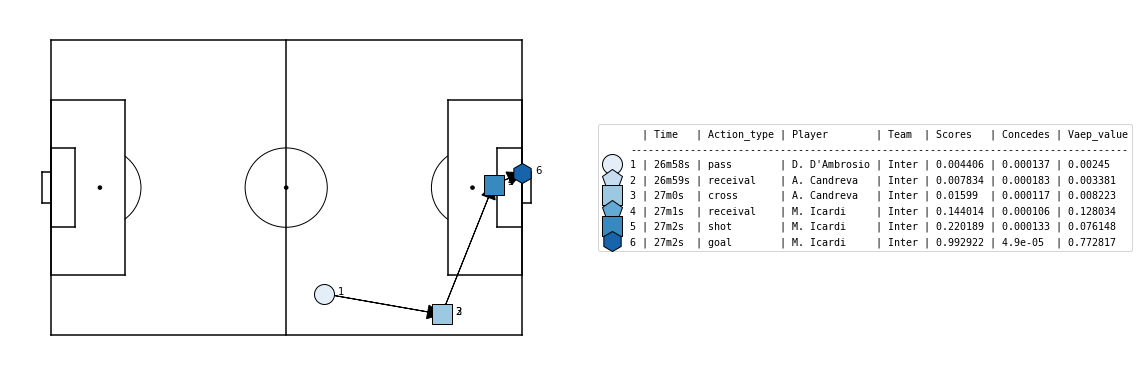

In [58]:
#For each game in the test set, append the predictions and compute vaep
B = []
actions = pd.HDFStore(spadl_h5) [f"actions/game_2576034"]
actions = (
        atomicspadl.add_names(actions)
        .merge(players, how="left")
        .merge(teams, how="left",)
        .sort_values(["game_id", "period_id", "action_id"])
        .reset_index(drop=True)
)
preds = pd.HDFStore(predictions_h5) [f"game_2576034"]
values = vaepformula.value(actions, preds.scores, preds.concedes)
B.append(pd.concat([actions, preds, values], axis=1))

B = pd.concat(B).sort_values(["game_id", "period_id", "time_seconds"]).reset_index(drop=True)
B['scores'] = B['scores'].round(decimals = 6)
B['concedes'] = B['concedes'].round(decimals = 6)
B['vaep_value'] = B['vaep_value'].round(decimals = 6)

#Plot
a = B.copy()
#Actions.type_name
pos = a[a.type_name == 'goal' ][0:1].action_id.values[0]
a = a[pos-5 : pos+1].copy()

a["start_x"] = a.x
a["start_y"] = a.y
a["end_x"] = a.x + a.dx
a["end_y"] = a.y + a.dy

game = games[(games.country_name == "Italy") & (games.home_team_name_short == "Internazionale") & (games.away_team_name_short== "Milan")]
g = game.iloc[0]
minute = int((a.period_id.values[0] - 1) * 45 + a.time_seconds.values[0] // 60)
game_info = f"{g.game_date}, {g.home_team_name} - {g.away_team_name} : {g.home_score}-{g.away_score} , {a[-1:].player_name.values[0]} {minute + 1}"
print(game_info)

   
a["nice_time"] = a.apply(nice_time,axis=1)
labels = a[["nice_time", "type_name", "nickname", "team_name_short",'scores','concedes','vaep_value']]
labels[['team_name_short']] = 'Inter'
#labels.iloc[-1:,4:5] = 1
matplotsoccer.actions(
    location=a[["start_x", "start_y", "end_x", "end_y"]],
    action_type=a.type_name,
    team= a.team_name,
    label=labels,
    labeltitle=["Time", "Action_type", "Player", "Team",'Scores','Concedes','Vaep_value'],
    zoom=False,
    figsize=10
)


In [54]:
labels.iloc[-1:,4:5] = 1

In [55]:
labels

,nice_time,type_name,nickname,team_name_short,scores,concedes,vaep_value
579,26m58s,pass,D. D'Ambrosio,Inter,0.004406,0.000137,0.002450
580,26m59s,receival,A. Candreva,Inter,0.007834,0.000183,0.003381
581,27m0s,cross,A. Candreva,Inter,0.015990,0.000117,0.008223
582,27m1s,receival,M. Icardi,Inter,0.144014,0.000106,0.128034
583,27m2s,shot,M. Icardi,Inter,0.220189,0.000133,0.076148
584,27m2s,goal,M. Icardi,Inter,1.000000,0.000049,0.772817


In [121]:
#Icardi + 0.95 per 1 gol

In [56]:
A.type_name.unique()

array(['pass', 'receival', 'dribble', 'take_on', 'interception', 'foul',
       'freekick', 'cross', 'out', 'goalkick', 'clearance', 'throw_in',
       'shot', 'keeper_save', 'offside', 'tackle', 'corner', 'goal',
       'shot_penalty', 'bad_touch', 'owngoal'], dtype=object)

2017-10-15 18:45:00, FC Internazionale Milano - AC Milan : 3-2 , Milan Škriniar 10'


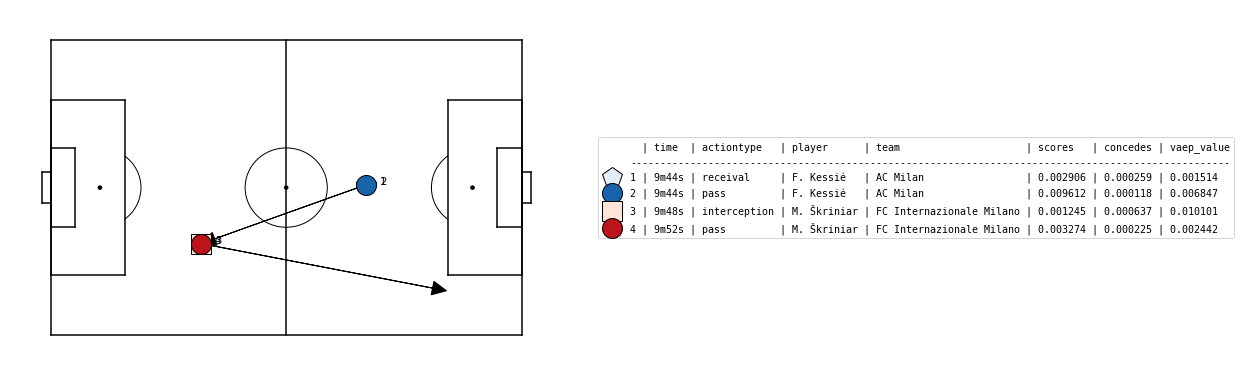

In [57]:
#Plot
a = B.copy()
#Actions.type_name
pos = a[a.type_name == 'interception' ][21:22].action_id.values[0]
a = a[pos-2 : pos+2].copy()

a["start_x"] = a.x
a["start_y"] = a.y
a["end_x"] = a.x + a.dx
a["end_y"] = a.y + a.dy

g = game.iloc[0]
minute = int((a.period_id.values[0] - 1) * 45 + a.time_seconds.values[0] // 60)
game_info = f"{g.game_date}, {g.home_team_name} - {g.away_team_name} : {g.home_score}-{g.away_score} , {a[-1:].player_name.values[0]} {minute + 1}'"
print(game_info)

   
a["nice_time"] = a.apply(nice_time,axis=1)
labels = a[["nice_time", "type_name", "nickname", "team_name",'scores','concedes','vaep_value']]

matplotsoccer.actions(
    location=a[["start_x", "start_y", "end_x", "end_y"]],
    action_type=a.type_name,
    team= a.team_name,
    label=labels,
    labeltitle=["time", "actiontype", "player", "team",'scores','concedes','vaep_value'],
    zoom=False,
    figsize=10
)


In [44]:
#Skriniar intercetta + passa  +0.005

2017-10-15 18:45:00, FC Internazionale Milano - AC Milan : 3-2 , Mauro Emanuel Icardi Rivero  66'


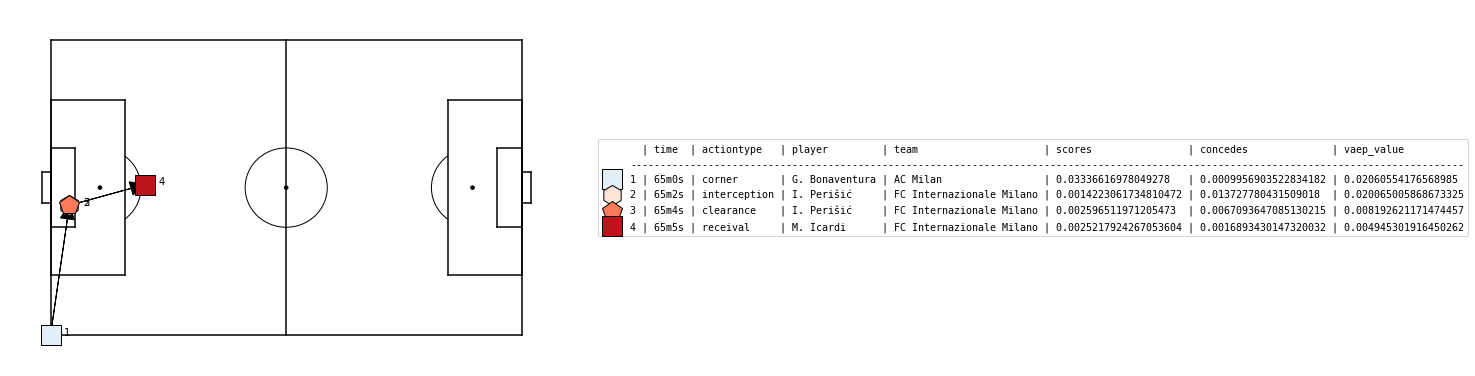

In [45]:
#Plot
a = B.copy()
#Actions.type_name
pos = a[a.type_name == 'clearance' ][13:14].action_id.values[0]
a = a[pos-2 : pos+2].copy()

a["start_x"] = a.x
a["start_y"] = a.y
a["end_x"] = a.x + a.dx
a["end_y"] = a.y + a.dy

g = game.iloc[0]
minute = int((a.period_id.values[0] - 1) * 45 + a.time_seconds.values[0] // 60)
game_info = f"{g.game_date}, {g.home_team_name} - {g.away_team_name} : {g.home_score}-{g.away_score} , {a[-1:].player_name.values[0]} {minute + 1}'"
print(game_info)

   
a["nice_time"] = a.apply(nice_time,axis=1)
labels = a[["nice_time", "type_name", "nickname", "team_name",'scores','concedes','vaep_value']]

matplotsoccer.actions(
    location=a[["start_x", "start_y", "end_x", "end_y"]],
    action_type=a.type_name,
    team= a.team_name,
    label=labels,
    labeltitle=["time", "actiontype", "player", "team",'scores','concedes','vaep_value'],
    zoom=False,
    figsize=10
)

In [46]:
#Perisic rinvia + 0.028

NameError: name 'all_games' is not defined

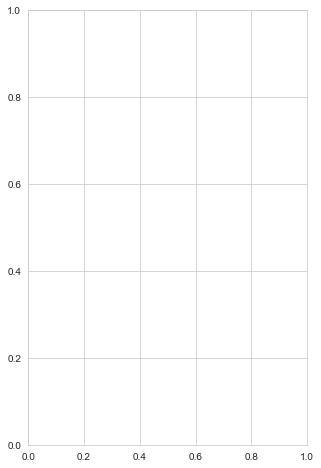

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
fig, axs = plt.subplots(figsize = (5,8))
sns.barplot(data = all_games, x = all_games.Count, y = all_games.index)
plt.ylabel('Action')